# **Задание Ultra pro**

1. Возьмите любую базу, которую мы решали с помощью нейронок.

2. Напишите настройку такой сети с помощью ГА.

3. Сделайте мощную сеть самостоятельно.

4. Добейтесь, чтобы у ГА точность была выше, чем у вашей сети.

Подсказка: ГА требует большой вычислительной мощности, лучше взять базу, которая требует довольно простую сеть и на которой обучение идёт быстро.

*********************************************

В данной работе будет использована база **по обнаружению мин**. Так как она довольна простая.

*********************************************

# Подключение библиотек


In [ ]:
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Reshape, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MAE
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from PIL import Image
from google.colab import files
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Подготовка данных для обучения сети

In [ ]:
# Загружаем файл с данными sonar.csv
files.upload()
!ls

Saving sonar.csv to sonar.csv
sample_data  sonar.csv


In [ ]:
# Загружаем данные из файла sonar.csv
df = pd.read_csv('sonar.csv', header=None)
print(df.shape) # Размерность данных
df.head()

(208, 61)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [ ]:
dataset = df.values                 # Берем только значения массива(без индексов)
X = dataset[:,0:60].astype(float)   # Присваиваем переменной Х значения с 0 по 60 колонки, тип данных float
Y = dataset[:,60]                   # А переменной Y данные из столбца с индексом 60

Y[Y=='R']='0'                       # Если значение элемента столбца равно 'R', присваеваем ему значение '0'
Y[Y=='M']='1'                       # Если значение элемента столбца равно 'Y', присваеваем ему значение '1'
Y = Y.astype(int)                   # Меняем тип данных столбца на 'int'(целочисленный тип данных)     

In [ ]:
# Будет выделено 20% от тренировочных данных на тестовую, и будут перемешаны
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Создание нейронной сети для сраврения

In [ ]:
# model = Sequential()

# model.add(Dense(60, input_dim=60, activation='relu'))
# model.add(Dense(30,  activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# history = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_split=0.2, verbose=0)

# print("Количество эпох: 50")
# print(f"Ошибка на тестовой выборке  : {round(history.history['val_loss'][-1], 4)}")
# print(f"Точность на тестовой выборке: {100 * round(history.history['val_accuracy'][-1], 2)} %")

## Проверяем качество обучения на тестовом наборе данных

In [ ]:
# # Вычисляем результаты сети на тестовом наборе
# scores_drop = model.evaluate(x_test, y_test, verbose=1)
# print("Верных ответов: ", round(scores_drop[1] * 100, 4), "%", sep="")

# Реализация **ГА**

### Необходимые функции

In [ ]:
# Функция получения родителей
def getParents(curr_popul, nsurv):
  indexp1 = random.randint(0, nsurv - 1)
  indexp2 = random.randint(0, nsurv - 1)
  botp1 = curr_popul[indexp1]
  botp2 = curr_popul[indexp2]
  return botp1, botp2

In [ ]:
# Функция смешивания (кроссинговера) двух родителей
def crossPointFrom2Parents(botp1, botp2, j):
  pindex = random.random()
  if pindex < 0.5:
    x = botp1[j]
  else:
    x = botp2[j]
  return x

In [ ]:
# Функция вычисления результата работы сети
def evaluateNet(net, epochs=100, verb=False):
  val = 0
  #time.time()
  model = createConvNet(net)
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test ,y_test), verbose=verb)
  val = history.history['val_accuracy'][-1]
  return val #, model

# Первый вариант

## Подбор архитектуры 

In [ ]:
# Функция создания списка случайных параметров
def createRandomNet():
  net = []
  net.append(random.randint(0,1))  # 0- Нормализация 0,1
  net.append(random.randint(2,50)) # 1- Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 2- Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 3- Функция активации первого слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 4- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 5- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)


  net.append(random.randint(0,1))  # 6 - Будет ли добавлен второй блок
  net.append(random.randint(0,1))  # 7-  Нормализация 0,1
  net.append(random.randint(2,50)) # 8-  Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 9-  Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 10- Функция активации второго слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 11- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 12- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  net.append(random.randint(0,1))  # 13 - Будет ли добавлен третий блок
  net.append(random.randint(0,1))  # 14-  Нормализация 0,1
  net.append(random.randint(2,50)) # 15-  Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 16- Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 17- Функция активации третьего слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 18- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 19- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  net.append(random.randint(0,1))  # 20 - Будет ли добавлен четвертый блок
  net.append(random.randint(0,1))  # 21-  Нормализация 0,1
  net.append(random.randint(2,50)) # 22-  Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 23- Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 24- Функция активации четвертого слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 25- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 26- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)


  net.append(random.randint(0,1))  # 27- Нормализация 0,1(Перед выходным слоем)
  net.append(random.randint(0,4))  # 28- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid']

  return net

In [ ]:
# Функция создания модели
def createConvNet(net):
 
  makeFirstNormalization = net[0]       # 0 - Нормализация в начале 0,1
  firstDenseNeurons = net[1]            # 1-  Число нейронов(которое будут изменяться)
  firstСhangeNeurons = net[2]           # 2-  Способ изменения нейронов в Dense слое(0-умножение на 10; 1-степень)
  activation1 = net[3]                  # 3-  Функция активации первого слоя - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut1 = net[4]                 # 4 - Будет ли Dropout 0,1
  firstDropout = net[5]                 # 5 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  secondLaeyrsDense = net[6]            # 6 - Будет ли добавлен второй блок
  makeSecondNormalization = net[7]      # 7 - Нормализация второго блока
  secondDenseNeurons = net[8]           # 8-  Число нейронов(которое будут изменяться)
  secondСhangeNeurons = net[9]          # 9-  Способ изменения нейронов в Dense слое
  activation2 = net[10]                 # 10- Функция активации второго блока - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut2 = net[11]                # 11- Будет ли Dropout 0,1
  secondDropout = net[12]               # 12- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  thirdLaeyrsDense = net[13]            # 13- Будет ли добавлен третий блок
  makeThirdNormalization = net[14]      # 14- Нормализация второго блока
  thirdDenseNeurons = net[15]           # 15- Число нейронов(которое будут изменяться)
  thirdСhangeNeurons = net[16]          # 16- Способ изменения нейронов в Dense слое
  activation3 = net[17]                 # 17- Функция активации третьего блока - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut3 = net[18]                # 18- Будет ли Dropout 0,1
  thirdDropout = net[19]                # 19- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)


  fourthLaeyrsDense = net[20]           # 20- Будет ли добавлен четвертый блок
  makeFourthNormalization = net[21]     # 21- Нормализация второго блока
  fourthDenseNeurons = net[22]          # 22- Число нейронов(которое будут изменяться)
  fourthСhangeNeurons = net[23]         # 23- Способ изменения нейронов в Dense слое
  activation4 = net[24]                 # 24- Функция активации четвертого блока - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut4 = net[25]                # 25- Будет ли Dropout 0,1
  fourthDropout = net[26]               # 26- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  finalNormalization = net[27]          # 21- Нормализация перед выходным слоем
  activation5 = net[28]                 # 24- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid'] - без tanh


  activation_list = ['linear','relu','elu','softmax','sigmoid','tanh']
  dropout_list = [0.25, 0.3, 0.35, 0.4]

  shape = (60,)

  model = Sequential()

  if makeFirstNormalization:                                                              # Нормализация в начале 
    model.add(BatchNormalization(input_shape=(shape)))
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1]))    # Добавление Dense слоя
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1]))
  
  else:  # Или без нормализации
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1], input_shape=(shape)))
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1], input_shape=(shape)))
  
  if makeDropOut1:   # Будет ли Dropout
    model.add(Dropout(dropout_list[firstDropout]))



  if secondLaeyrsDense:   #  Будет ли второй блок

    if makeSecondNormalization:
      model.add(BatchNormalization())

    if secondСhangeNeurons:
      model.add(Dense(secondDenseNeurons**2, activation=activation_list[activation2]))
    else:
      model.add(Dense(secondDenseNeurons*10, activation=activation_list[activation2]))

    if makeDropOut2:   # Будет ли Dropout
      model.add(Dropout(dropout_list[secondDropout]))


  if thirdLaeyrsDense:   #  Будет ли третий блок

    if makeThirdNormalization:
      model.add(BatchNormalization())

    if thirdСhangeNeurons:
      model.add(Dense(thirdDenseNeurons**2, activation=activation_list[activation3]))
    else:
      model.add(Dense(thirdDenseNeurons*10, activation=activation_list[activation3]))

    if makeDropOut3:   # Будет ли Dropout
      model.add(Dropout(dropout_list[thirdDropout]))


  if fourthLaeyrsDense:   #  Будет ли четвертый блок

      if makeFourthNormalization:
        model.add(BatchNormalization())

      if fourthСhangeNeurons:
        model.add(Dense(fourthDenseNeurons**2, activation=activation_list[activation4]))
      else:
        model.add(Dense(fourthDenseNeurons*10, activation=activation_list[activation4]))

      if makeDropOut4:   # Будет ли Dropout
        model.add(Dropout(dropout_list[fourthDropout]))

  
  if finalNormalization:   # Нормализация перед выходным слоем
    model.add(BatchNormalization())
  
  model.add(Dense(1, activation=activation_list[activation5]))  #  Без tanh

  return model

In [ ]:
n = 50            # Общее число ботов
nsurv = 10        # Кол-во выживших
nnew = n - nsurv  # Кол-во новых
l = 29            # Размер бота
epochs = 50       # Количество эпох

mut = 0.99        # Коэфициент мутаций

In [ ]:
start_time = time.time()
popul = []
#val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()
  #print(f"Эпоха {ep}:")
  
  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot)
    #print(f"Бот: {i} готов")
    val.append(f)

  sval = sorted(val, reverse=True)

  end_time = time.time() - curr_time
  print(f"Эпоха {ep}  --- время: {round(end_time, 2)} ")
  print(f'Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:5]}')
  print()

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)
  
  popul = newpopul

Эпоха 0  --- время: 242.14 
Лучшие результаты: [0.8571428656578064, 0.8571428656578064, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184]  ----- Лучшие боты: [[1, 50, 0, 3, 1, 0, 1, 0, 47, 1, 5, 1, 0, 1, 0, 12, 0, 1, 0, 1, 1, 0, 31, 1, 0, 1, 2, 0, 1], [1, 28, 1, 5, 0, 2, 0, 1, 7, 0, 1, 0, 2, 0, 1, 26, 1, 5, 0, 2, 0, 1, 42, 0, 0, 1, 3, 1, 4], [1, 8, 0, 2, 0, 3, 1, 0, 11, 1, 0, 1, 0, 1, 0, 44, 1, 4, 1, 3, 0, 1, 50, 0, 4, 1, 3, 1, 2], [1, 38, 0, 4, 0, 3, 0, 0, 15, 1, 5, 0, 0, 1, 0, 26, 1, 5, 1, 1, 1, 1, 19, 0, 1, 0, 2, 1, 1], [1, 38, 1, 1, 1, 3, 1, 1, 50, 1, 2, 1, 3, 1, 1, 40, 1, 4, 1, 0, 1, 1, 15, 0, 2, 0, 3, 0, 0]]

Эпоха 1  --- время: 230.82 
Лучшие результаты: [0.8571428656578064, 0.8095238208770752, 0.8095238208770752, 0.8095238208770752, 0.7857142686843872]  ----- Лучшие боты: [[1, 38, 0, 4, 0, 3, 0, 0, 15, 1, 5, 0, 0, 1, 0, 26, 1, 5, 1, 1, 1, 1, 19, 0, 1, 0, 2, 1, 1], [1, 38, 0, 4, 0, 3, 0, 0, 15, 1, 5, 0, 0, 1, 0, 26, 1, 5, 1, 1, 1, 1, 19, 0, 1, 0, 2, 1, 1], [1, 8, 0, 2,

## Проверка результатов

In [ ]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[0, 26, 1, 2, 1, 0, 0, 0, 37, 1, 3, 1, 2, 0, 1, 37, 0, 0, 0, 3, 1, 1, 28, 1, 2, 0, 0, 0, 4]
[0, 26, 1, 2, 1, 0, 0, 0, 37, 1, 3, 1, 2, 0, 1, 37, 0, 0, 0, 3, 1, 1, 28, 1, 2, 0, 0, 0, 4]
[0, 26, 1, 2, 1, 0, 0, 0, 37, 1, 3, 1, 2, 0, 1, 37, 0, 0, 0, 3, 1, 1, 28, 1, 2, 0, 0, 0, 4]


## Обучение лучшей модели

In [ ]:
model = createConvNet(popul[0])

### Архитектура сети

In [ ]:
model.summary()

Model: "sequential_2500"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8664 (Dense)          (None, 676)               41236     
                                                                 
 dropout_2999 (Dropout)      (None, 676)               0         
                                                                 
 batch_normalization_4098 (B  (None, 676)              2704      
 atchNormalization)                                              
                                                                 
 dense_8665 (Dense)          (None, 784)               530768    
                                                                 
 dense_8666 (Dense)          (None, 1)                 785       
                                                                 
Total params: 575,493
Trainable params: 574,141
Non-trainable params: 1,352
_________________________________________

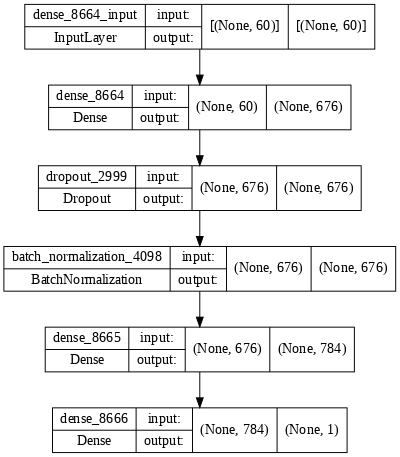

In [ ]:
plot_model(model, show_shapes=True, dpi = 70)

## Обучим лучшую архитектуру

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=200, validation_data=(x_test ,y_test), verbose=True)

Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 0.7675 - accuracy: 0.5361 - val_loss: 0.6674 - val_accuracy: 0.6429
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 0.6191 - accuracy: 0.6566 - val_loss: 0.6522 - val_accuracy: 0.6429
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 0.4921 - accuracy: 0.7530 - val_loss: 0.6381 - val_accuracy: 0.6190
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.5226 - accuracy: 0.7410 - val_loss: 0.6261 - val_accuracy: 0.6190
Epoch 5/200
6/6 [==============================] - 0s 13ms/step - loss: 0.4907 - accuracy: 0.7590 - val_loss: 0.6222 - val_accuracy: 0.6190
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 0.4959 - accuracy: 0.7711 - val_loss: 0.6248 - val_accuracy: 0.5952
Epoch 7/200
6/6 [==============================] - 0s 10ms/step - loss: 0.4533 - accuracy: 0.7831 - val_loss: 0.6237 - val_accuracy: 0.6190
Epoch 8/200
6/6 [====

# Второй вариант
**Более простая архитектура сети. Меньше гиперпараметров.**

In [ ]:
def createRandomNet():
  net = []
  net.append(random.randint(0,1))  # 0- Нормализация 0,1
  net.append(random.randint(2,10)) # 1- Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 2- Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 3- Функция активации первого слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 4- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 5- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)


  net.append(random.randint(0,1))  # 6 - Будет ли добавлен второй блок
  net.append(random.randint(0,1))  # 7-  Нормализация 0,1
  net.append(random.randint(2,10)) # 8-  Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 9-  Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 10- Функция активации второго слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 11- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 12- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  net.append(random.randint(0,1))  # 27- Нормализация 0,1(Перед выходным слоем)
  net.append(random.randint(0,4))  # 28- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid']

  return net

In [ ]:
def createConvNet(net):
 
  makeFirstNormalization = net[0]       # 0 - Нормализация в начале 0,1
  firstDenseNeurons = net[1]            # 1-  Число нейронов(которое будут изменяться)
  firstСhangeNeurons = net[2]           # 2-  Способ изменения нейронов в Dense слое(0-умножение на 10; 1-степень)
  activation1 = net[3]                  # 3-  Функция активации первого слоя - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut1 = net[4]                 # 4 - Будет ли Dropout 0,1
  firstDropout = net[5]                 # 5 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  secondLaeyrsDense = net[6]            # 6 - Будет ли добавлен второй блок
  makeSecondNormalization = net[7]      # 7 - Нормализация второго блока
  secondDenseNeurons = net[8]           # 8-  Число нейронов(которое будут изменяться)
  secondСhangeNeurons = net[9]          # 9-  Способ изменения нейронов в Dense слое
  activation2 = net[10]                 # 10- Функция активации второго блока - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut2 = net[11]                # 11- Будет ли Dropout 0,1
  secondDropout = net[12]               # 12- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  finalNormalization = net[13]          # 13- Нормализация перед выходным слоем
  activation5 = net[14]                 # 14- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid'] - без tanh


  activation_list = ['linear','relu','elu','softmax','sigmoid','tanh']
  dropout_list = [0.25, 0.3, 0.35, 0.4]

  shape = (60,)

  model = Sequential()

  if makeFirstNormalization:                                                              # Нормализация в начале 
    model.add(BatchNormalization(input_shape=(shape)))
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1]))    # Добавление Dense слоя
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1]))
  
  else:  # Или без нормализации
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1], input_shape=(shape)))
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1], input_shape=(shape)))
  
  if makeDropOut1:   # Будет ли Dropout
    model.add(Dropout(dropout_list[firstDropout]))



  if secondLaeyrsDense:   #  Будет ли второй блок

    if makeSecondNormalization:
      model.add(BatchNormalization())

    if secondСhangeNeurons:
      model.add(Dense(secondDenseNeurons**2, activation=activation_list[activation2]))
    else:
      model.add(Dense(secondDenseNeurons*10, activation=activation_list[activation2]))

    if makeDropOut2:   # Будет ли Dropout
      model.add(Dropout(dropout_list[secondDropout]))


  if finalNormalization:   # Нормализация перед выходным слоем
    model.add(BatchNormalization())
  
  model.add(Dense(1, activation=activation_list[activation2]))  #  Без tanh

  return model

In [ ]:
n = 50            # Общее число ботов
nsurv = 10        # Кол-во выживших
nnew = n - nsurv  # Кол-во новых
l = 15            # Размер бота
epochs = 50       # Количество эпох

mut = 0.99        # Коэфициент мутаций

In [ ]:
start_time = time.time()
popul = []
#val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()
  #print(f"Эпоха {ep}:")
  
  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot)
    #print(f"Бот: {i} готов")
    val.append(f)

  sval = sorted(val, reverse=True)

  end_time = time.time() - curr_time
  print(f"Эпоха {ep}  --- время: {round(end_time, 2)} ")
  print(f'Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:5]}')
  print()

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)
  
  popul = newpopul

Эпоха 0  --- время: 204.62 
Лучшие результаты: [0.8095238208770752, 0.7857142686843872, 0.761904776096344, 0.761904776096344, 0.738095223903656]  ----- Лучшие боты: [[0, 5, 1, 4, 1, 0, 0, 1, 3, 1, 4, 1, 1, 1, 2], [1, 4, 1, 4, 1, 1, 0, 1, 2, 0, 5, 0, 0, 1, 2], [0, 7, 1, 3, 0, 2, 1, 1, 2, 1, 4, 0, 1, 1, 1], [0, 2, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 2, 0, 2], [0, 8, 0, 4, 1, 1, 1, 0, 4, 0, 1, 1, 0, 0, 0]]

Эпоха 1  --- время: 206.77 
Лучшие результаты: [0.8095238208770752, 0.738095223903656, 0.738095223903656, 0.738095223903656, 0.6904761791229248]  ----- Лучшие боты: [[1, 3, 0, 5, 0, 3, 0, 0, 6, 0, 4, 1, 1, 0, 1], [1, 7, 1, 4, 1, 2, 0, 0, 2, 0, 4, 0, 1, 1, 1], [1, 9, 1, 0, 0, 2, 0, 1, 6, 1, 4, 1, 0, 0, 0], [1, 9, 1, 0, 0, 2, 0, 1, 6, 1, 4, 1, 0, 0, 0], [1, 5, 0, 1, 0, 3, 1, 0, 8, 1, 1, 0, 3, 0, 1]]

Эпоха 2  --- время: 213.04 
Лучшие результаты: [0.761904776096344, 0.761904776096344, 0.738095223903656, 0.738095223903656, 0.738095223903656]  ----- Лучшие боты: [[1, 7, 1, 4, 1, 2, 0, 0, 2, 0, 4

## Проверка результатов

In [ ]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[1, 10, 1, 1, 0, 3, 0, 0, 4, 0, 4, 0, 1, 0, 1]
[1, 10, 1, 1, 0, 3, 0, 0, 4, 0, 4, 0, 1, 0, 1]
[1, 10, 1, 1, 0, 3, 0, 0, 4, 0, 4, 0, 1, 0, 1]


## Обучение лучшей модели

In [ ]:
model = createConvNet(popul[0])

### Архитектура сети

In [ ]:
model.summary()

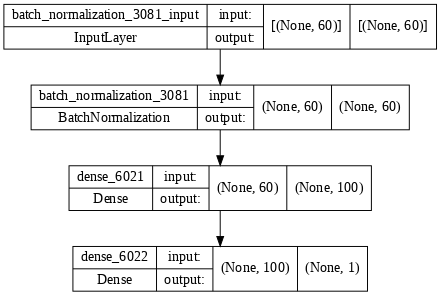

In [ ]:
plot_model(model, show_shapes=True, dpi = 70)

## Обучим лучшую архитектуру

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=200, validation_data=(x_test ,y_test), verbose=True)

Epoch 1/200
6/6 [==============================] - 2s 129ms/step - loss: 0.7368 - accuracy: 0.5301 - val_loss: 0.6851 - val_accuracy: 0.5952
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7313 - accuracy: 0.5361 - val_loss: 0.6838 - val_accuracy: 0.5952
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7046 - accuracy: 0.5964 - val_loss: 0.6824 - val_accuracy: 0.5952
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.7014 - accuracy: 0.5964 - val_loss: 0.6809 - val_accuracy: 0.5952
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6838 - accuracy: 0.5964 - val_loss: 0.6796 - val_accuracy: 0.5952
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6770 - accuracy: 0.5783 - val_loss: 0.6779 - val_accuracy: 0.5952
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 0.6618 - accuracy: 0.6265 - val_loss: 0.6757 - val_accuracy: 0.5952
Epoch 8/200
6/6 [=====

# Третий вариант
**Один блок**

In [ ]:
def createRandomNet():
  net = []
  net.append(random.randint(0,1))  # 0- Нормализация 0,1
  net.append(random.randint(2,50)) # 1- Число нейронов(которое будут изменяться)
  net.append(random.randint(0,1))  # 2- Способ изменения нейронов в Dense слое
  net.append(random.randint(0,5))  # 3- Функция активации первого слоя - ['linear','relu','elu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))  # 4- Будет ли Dropout 0,1
  net.append(random.randint(0,3))  # 5- Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)


  net.append(random.randint(0,1))  # 6- Нормализация 0,1(Перед выходным слоем)
  net.append(random.randint(0,4))  # 7- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid']

  return net

In [ ]:
def createConvNet(net):
 
  makeFirstNormalization = net[0]       # 0 - Нормализация в начале 0,1
  firstDenseNeurons = net[1]            # 1-  Число нейронов(которое будут изменяться)
  firstСhangeNeurons = net[2]           # 2-  Способ изменения нейронов в Dense слое(0-умножение на 10; 1-степень)
  activation1 = net[3]                  # 3-  Функция активации первого слоя - ['linear','relu','elu','softmax','sigmoid','tanh']
  makeDropOut = net[4]                  # 4 - Будет ли Dropout 0,1
  firstDropout = net[5]                 # 5 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  finalNormalization = net[6]           # 6- Нормализация перед выходным слоем
  activation2 = net[7]                  # 7- Функция активации выходного слоя - ['linear','relu','elu','softmax','sigmoid'] - без tanh


  activation_list = ['linear','relu','elu','softmax','sigmoid','tanh']
  dropout_list = [0.25, 0.3, 0.35, 0.4]

  shape = (60,)

  model = Sequential()

  if makeFirstNormalization:                                                              # Нормализация в начале 
    model.add(BatchNormalization(input_shape=(shape)))
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1]))    # Добавление Dense слоя
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1]))
  
  else:  # Или без нормализации
    if firstСhangeNeurons:
      model.add(Dense(firstDenseNeurons**2, activation=activation_list[activation1], input_shape=(shape)))
    else:
      model.add(Dense(firstDenseNeurons*10, activation=activation_list[activation1], input_shape=(shape)))
  
  if makeDropOut:   # Будет ли Dropout
    model.add(Dropout(dropout_list[firstDropout]))

  # Выходной слой
  if finalNormalization:   # Нормализация перед выходным слоем
    model.add(BatchNormalization())
  
  model.add(Dense(1, activation=activation_list[activation2]))  #  Без tanh

  return model

In [ ]:
n = 50            # Общее число ботов
nsurv = 10         # Кол-во выживших
nnew = n - nsurv   # Кол-во новых
l = 8              # Размер бота
epochs = 30        # Количество эпох

mut = 0.99         # Коэфициент мутаций

In [ ]:
start_time = time.time()
popul = []
#val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()
  #print(f"Эпоха {ep}:")
  
  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot)
    #print(f"Бот: {i} готов")
    val.append(f)

  sval = sorted(val, reverse=True)

  end_time = time.time() - curr_time
  print(f"Эпоха {ep}  --- время: {round(end_time, 2)} ")
  print(f'Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:5]}')
  print()

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)
  
  popul = newpopul

Эпоха 0  --- время: 400.25 
Лучшие результаты: [0.8571428656578064, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.8095238208770752]  ----- Лучшие боты: [[0, 37, 1, 1, 1, 2, 1, 2], [1, 12, 1, 4, 0, 3, 0, 2], [0, 30, 1, 5, 0, 2, 0, 3], [0, 46, 1, 0, 0, 0, 0, 0], [1, 38, 1, 3, 0, 1, 1, 3]]

Эпоха 1  --- время: 376.96 
Лучшие результаты: [0.8809523582458496, 0.8809523582458496, 0.8571428656578064, 0.8571428656578064, 0.8333333134651184]  ----- Лучшие боты: [[1, 50, 1, 1, 0, 0, 1, 4], [0, 34, 1, 2, 1, 2, 0, 4], [0, 34, 1, 2, 1, 2, 0, 4], [0, 34, 1, 2, 1, 2, 0, 4], [0, 37, 1, 1, 1, 2, 1, 2]]

Эпоха 2  --- время: 370.0 
Лучшие результаты: [0.8571428656578064, 0.8571428656578064, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184]  ----- Лучшие боты: [[1, 50, 1, 1, 0, 0, 1, 4], [1, 50, 1, 1, 0, 0, 1, 4], [0, 37, 1, 1, 1, 2, 1, 2], [0, 37, 1, 1, 1, 2, 1, 2], [0, 34, 1, 2, 1, 2, 0, 4]]

Эпоха 3  --- время: 338.46 
Лучшие результаты: [0.9047619104385376, 0.8809523582458496

## Проверка результатов

In [ ]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[1, 50, 1, 1, 0, 0, 1, 4]
[1, 50, 1, 1, 0, 0, 1, 4]
[1, 50, 1, 1, 0, 0, 1, 4]


## Обучение лучшей модели

In [ ]:
model = createConvNet(popul[0])

### Архитектура сети

In [ ]:
model.summary()

Model: "sequential_1500"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1765 (B  (None, 60)               240       
 atchNormalization)                                              
                                                                 
 dense_3000 (Dense)          (None, 2500)              152500    
                                                                 
 batch_normalization_1766 (B  (None, 2500)             10000     
 atchNormalization)                                              
                                                                 
 dense_3001 (Dense)          (None, 1)                 2501      
                                                                 
Total params: 165,241
Trainable params: 160,121
Non-trainable params: 5,120
_________________________________________________________________


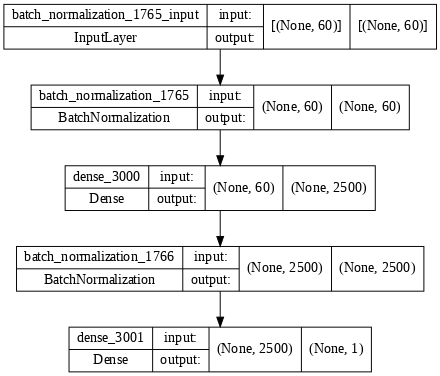

In [ ]:
plot_model(model, show_shapes=True, dpi = 70)

# Обучим лучшую архитектуру

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test ,y_test), verbose=True)

Epoch 1/200
6/6 [==============================] - 2s 102ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.4447 - val_accuracy: 0.9048
Epoch 2/200
6/6 [==============================] - 0s 26ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.9048
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0223 - accuracy: 0.9940 - val_loss: 0.3828 - val_accuracy: 0.9048
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0074 - accuracy: 0.9940 - val_loss: 0.3675 - val_accuracy: 0.9048
Epoch 5/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3607 - val_accuracy: 0.9048
Epoch 6/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0064 - accuracy: 0.9940 - val_loss: 0.3571 - val_accuracy: 0.9048
Epoch 7/200
6/6 [==============================] - 0s 21ms/step - loss: 8.5704e-04 - accuracy: 1.0000 - val_loss: 0.3370 - val_accuracy: 0.9048
Epoch 8/200
6/6

In [ ]:
print(f"Максимальная точность: {round(max(history.history['val_accuracy']) * 100, 2)} %")

Максимальная точность: 95.24 %


# Выводы:

1. Для решения данного задания была выбрана довольно простая задача. Для того чтобы проводить множество различных экспериментов по времени. 
2. Использование **Генетических алгоритмов** поможет находить оптимальную архитектуру и гиперпараметры для конкретной задачи.
3. На каждый вариант уходило много времени на обучение. 
4. Если увеличивать популяцию, то время обучения увеличивается пропорционально. Но тогда добавляется большая вариативность, и остаются в качестве родителей лучшие особи.
5. Проделовая это вручную без **ГА**, можно потратить больше времени.
6. Как видно из экспериментов для решения данной задачи не требуется сложная архитектура. Довольно простая нейронная сеть дает результат не хуже, чем сеть с большим количеством слоев.
7. Так же с помощью **ГА** можно подбирать оптимальные гиперпараметры. 
8. Данная дамашняя работа помогает разобраться с построением **Генетических алгоритмов** для обучения нейронных сетей, что в дальнейшем очень пригодиться. 